In [1]:
from __future__ import print_function, division

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['figure.figsize'] = (10,6)
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator

from matplotlib import pyplot as plt
import seaborn as sns; sns.set(context="poster", style="ticks")
import ipywidgets
import yt

import glob
import os
import warnings
import h5py

import numpy as np
import pandas as pd

import pickle

from units import M_solar, m_proton, pc, yr, Myr, km, s, gamma

from injection_helpers import get_SNe

from visualize_helpers import \
    get_snapshot_filenames, \
    snapshot_filename_to_number, \
    total_mass_of_snapshot, \
    total_radial_momentum_of_snapshot, \
    map_to_all_snapshots, \
    get_snapshot_times, \
    total_kinetic_energy_of_snapshot, \
    total_internal_energy_of_snapshot, \
    load_snapshots, \
    plot_projected_density, \
    plot_sliced_field, \
    plot_phase_diagram, \
    field_type, \
    plot_profile, \
    yt_plot_saver, \
    mpl_plot_saver, \
    load_ds_from_ts

import MHD
    
from sql_helpers import add_simulation, \
    open_as_DataFrame, get_db_dirname_tmp
    
from scipy import optimize

%load_ext autoreload
%autoreload 2

`grackle_helpers.wrapped_initializer` is setting up grackle assuming code units:
    mass   : 1.0 M_solar
    length : 1.0 pc
    time   : 1.0 Myr

grackle cooling file:  b'/pfs/home/egentry/local/grackle/input/CloudyData_UVB=HM2012.h5'


In [2]:
publication_plots_dir = "publication_plots"

In [3]:
def get_dirs(run_name):
    
    run_dir = os.path.join(os.path.pardir, "runs", run_name)
    
    inputs_dir  = os.path.join(run_dir, "inputs")
    outputs_dir = os.path.join(run_dir, "outputs")

    return inputs_dir, outputs_dir

In [4]:
save_plots = True

In [5]:
inputs_dir_tmp = "../runs/cluster_cooling_200/inputs/"
SNe = get_SNe(inputs_dir_tmp)
SN_times           = np.array([SN.time          for SN in SNe])
SN_ejecta_masses   = np.array([SN.ejecta_mass   for SN in SNe])
SN_ejecta_masses_Z = np.array([SN.ejecta_mass_Z for SN in SNe])

In [6]:
## Boilerplate path hack to give access to full clustered_SNe package
import sys, os
if __package__ is None:
    if os.pardir not in sys.path[0]:
        file_dir = os.getcwd()
        sys.path.insert(0, os.path.join(file_dir, 
                                        os.pardir, 
                                        os.pardir))
        
from clustered_SNe.analysis.parse import Overview, RunSummary

data_dir_1D = "1D_data/"

run_summary = RunSummary(data_dir_1D, "F5509BF1-3F9E-4008-B795-0482ECED199B")

# Create the grid

In [7]:
from grackle_helpers import wrapped_initializer, FluidContainer

# Remember, grackle often breaks if you try to use cgs units -_- 
# (https://groups.google.com/d/topic/grackle-cooling-users/DvL5oIIuz3Q/discussion)

rval, my_chemistry = wrapped_initializer(
    m_proton, # grackle breaks if you try to use cgs units -_- 
    1,
    1,
    verbose=True,
    )
assert(rval == 1)

def grackle_temperature(df):

    fc = FluidContainer(my_chemistry, df.shape[0])

    fc["density"][:] = df.Density.values / m_proton
    fc["metal"][:] =  df.Density.values * df.Z.values / m_proton
    fc["x-velocity"][:] = df.Velocity.values
    fc["y-velocity"][:] = 0
    fc["z-velocity"][:] = 0
    gamma = 5/3
    specific_internal_energy = (1 / (gamma - 1)) * df.Pressure.values / df.Density.values
    fc["energy"][:] = specific_internal_energy

    fc.calculate_temperature()
    
    return fc["temperature"]

def grackle_cooling_rate(df):

    fc = FluidContainer(my_chemistry, df.shape[0])

    fc["density"][:] = df.Density.values / m_proton
    fc["metal"][:] =  df.Density.values * df.Z.values / m_proton
    fc["x-velocity"][:] = df.Velocity.values
    fc["y-velocity"][:] = 0
    fc["z-velocity"][:] = 0
    gamma = 5/3
    specific_internal_energy = (1 / (gamma - 1)) * df.Pressure.values / df.Density.values
    fc["energy"][:] = specific_internal_energy

    fc.calculate_temperature()
    fc.calculate_cooling_time()
    
    dt = 1 # [second]
    fc.solve_chemistry(dt)
    
    de = (specific_internal_energy - fc["energy"])
    
    de_dt = de / dt 
    
    dE_dt = de_dt * df.Mass.values * M_solar
    
    return dE_dt

`grackle_helpers.wrapped_initializer` is setting up grackle assuming code units:
    mass   : 8.41e-58 M_solar
    length : 3.24e-19 pc
    time   : 3.17e-14 Myr

grackle cooling file:  b'/pfs/home/egentry/local/grackle/input/CloudyData_UVB=HM2012.h5'


In [8]:
from astropy import constants as const

In [9]:
k_b = const.k_B.cgs.value

In [10]:
num_1D = 400
densities_1D = m_proton * np.logspace(-4,3, num=num_1D)
temperatures_1D = np.logspace(1,7, num=num_1D)

densities, temperatures = np.meshgrid(densities_1D, temperatures_1D)

In [11]:
def e_int_to_T(e_int, density):
        fc = FluidContainer(my_chemistry, 1)

        fc["density"][:] = density / m_proton
        fc["metal"][:] =  density * 0.02 / m_proton
        fc["x-velocity"][:] = 0
        fc["y-velocity"][:] = 0
        fc["z-velocity"][:] = 0

    
        fc["energy"][:] = e_int
        fc.calculate_temperature()
        
        return fc["temperature"][0]

    
pressure = (densities[0,0] / m_proton) * k_b * temperatures[0,0]
internal_energy_initial = (1 / (gamma - 1)) * pressure / densities[0,0]
e_int_to_T(internal_energy_initial, densities[0,0])

6.8746574774408478

In [12]:
def _T_resid(e_int, T_desired, density):
    return T_desired - e_int_to_T(e_int, density)

_T_resid(internal_energy_initial, temperatures[0,0], densities[0,0])

3.1253425225591522

In [13]:
e_int_actual = np.empty_like(densities)

for i, T_desired in enumerate(temperatures_1D):
    for j, density in enumerate(densities_1D):

        gamma = 5/3

        pressure = (density / m_proton) * k_b * T_desired
        internal_energy_initial = (1 / (gamma - 1)) * pressure / density
        
        results = optimize.minimize(_T_resid, 
                                    internal_energy_initial,
                                    args=(T_desired, density))
        
        e_int_actual[i,j] = results["x"][0]
        

#         break
#     break

In [14]:
num = e_int_actual.size

fc_new = FluidContainer(my_chemistry, num)

fc_new["density"][:] = densities.flatten() / m_proton
fc_new["metal"][:] =  densities.flatten() * 0.02 / m_proton
fc_new["x-velocity"][:] = 0
fc_new["y-velocity"][:] = 0
fc_new["z-velocity"][:] = 0
gamma = 5/3

fc_new["energy"][:] = e_int_actual.flatten()
fc_new.calculate_temperature()
fc_new.calculate_cooling_time()

temperatures_new = np.reshape(fc_new["temperature"], e_int_actual.shape)

## Check Temperatures Match

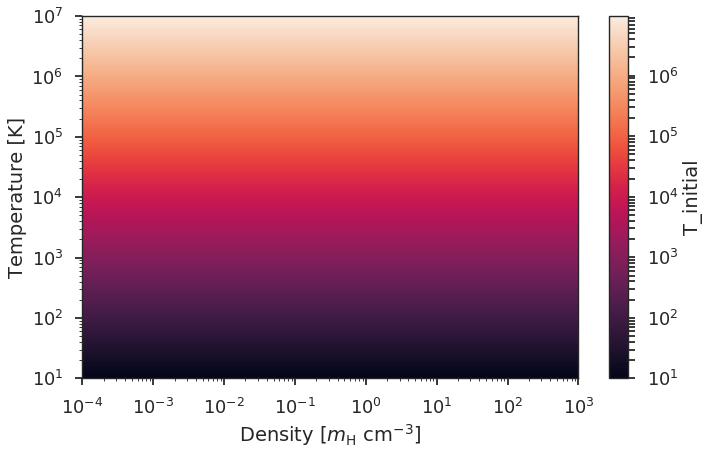

In [15]:
plt.pcolor(densities_1D / m_proton, temperatures_1D, 
           temperatures,
           norm = LogNorm())

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Density [$m_\mathrm{H}$ cm$^{-3}$]")
plt.ylabel("Temperature [K]")

plt.colorbar(label="T_initial")

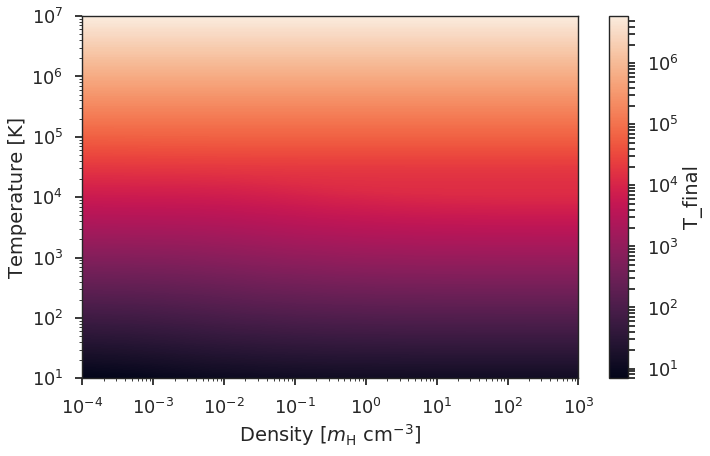

In [16]:
plt.pcolor(densities_1D / m_proton, temperatures_1D, 
           temperatures_new,
           norm = LogNorm())

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Density [$m_\mathrm{H}$ cm$^{-3}$]")
plt.ylabel("Temperature [K]")

plt.colorbar(label="T_final")

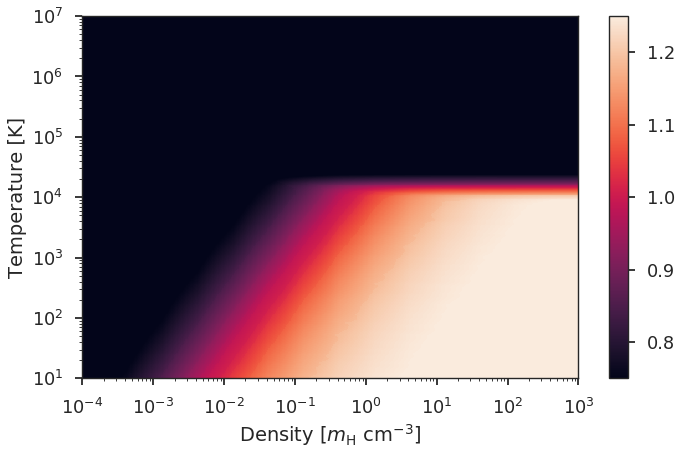

In [17]:
plt.pcolor(densities_1D / m_proton, temperatures_1D, 
           temperatures_new/temperatures,
           vmin=1-.25, vmax=1+.25,
          )

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Density [$m_\mathrm{H}$ cm$^{-3}$]")
plt.ylabel("Temperature [K]")

plt.colorbar()

## Cooling times

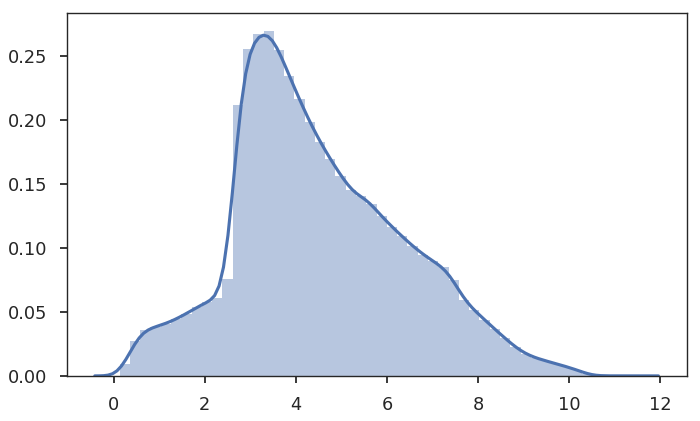

In [18]:
sns.distplot(
    np.log10(
        np.abs(
            fc_new["cooling_time"] / yr
        ).flatten()
    )
)

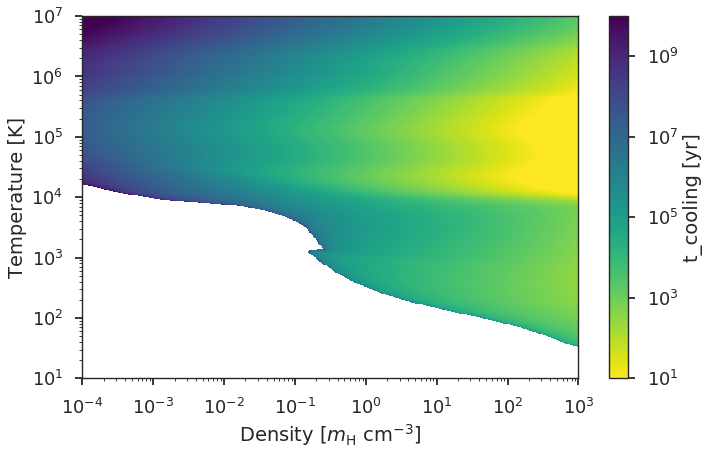

In [19]:
pc = plt.pcolor(densities_1D / m_proton, temperatures_1D, 
#            np.abs(
               -np.reshape(fc_new["cooling_time"], densities.shape) / yr
#            ) 
                ,
           norm = LogNorm(vmin=1e1, vmax=1e10),
                cmap=plt.get_cmap("viridis_r")
               )

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Density [$m_\mathrm{H}$ cm$^{-3}$]")
plt.ylabel("Temperature [K]")

plt.colorbar(pc,
             label="t_cooling [yr]",
             ticks = LogLocator(),
            )

### Now do the same thing, except with *absolute value* of cooling time.
(so net heating and net cooling map both show up)

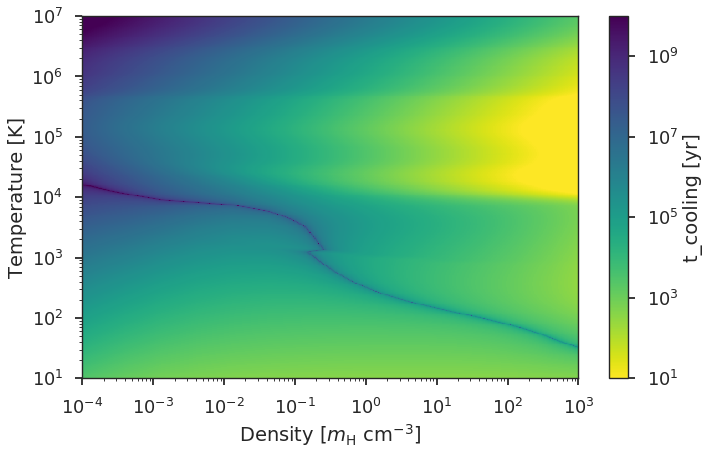

In [20]:
pc = plt.pcolor(densities_1D / m_proton, temperatures_1D, 
           np.abs(
               -np.reshape(fc_new["cooling_time"], densities.shape) / yr
           ) 
                ,
           norm = LogNorm(vmin=1e1, vmax=1e10),
                cmap=plt.get_cmap("viridis_r")
               )

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Density [$m_\mathrm{H}$ cm$^{-3}$]")
plt.ylabel("Temperature [K]")

plt.colorbar(pc,
             label="t_cooling [yr]",
             ticks = LogLocator(),
            )

## Cooling rates

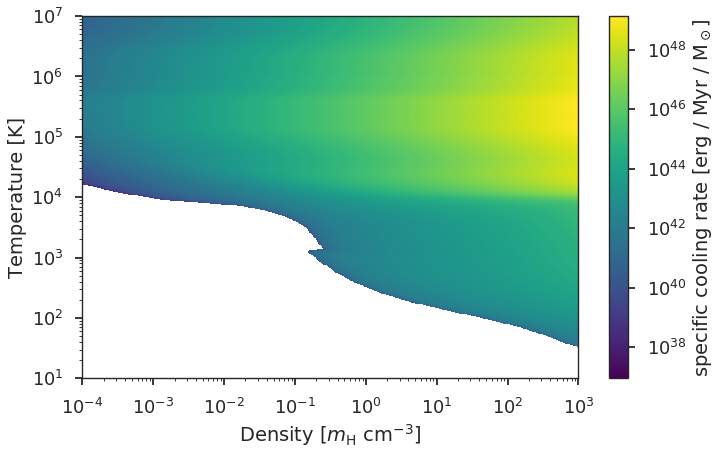

In [22]:
pc = plt.pcolor(densities_1D / m_proton, temperatures_1D, 
#            np.abs(
               np.reshape(
                   -fc_new["energy"] / fc_new["cooling_time"]
                   , densities.shape) / Myr * M_solar / m_proton
#            ) 
                ,
           norm = LogNorm(),
                cmap=plt.get_cmap("viridis")
               )

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Density [$m_\mathrm{H}$ cm$^{-3}$]")
plt.ylabel("Temperature [K]")

plt.colorbar(pc,
             label="specific cooling rate [erg / Myr / M$_\odot$]",
             ticks = LogLocator(),
            )